# Comparación de estrategias de Swing Trading: Buy&Hold VS 3MM

### Script de comparación

In [1]:
def trade_comparison(csv, equity, n_acciones, secure_profit, comision_fija, comision_por_accion, ref_value, p_mmr, p_mmi, p_mml,dias,volatilidad):
    
    
    #IMPORTACIÓN DE MÓDULOS
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.rc("figure", figsize=[16,9])

    
    #FUNCIONES AUXILIARES

    def MME(N,data):
        MME=N*["NaN"]
        MME.append(np.mean(data[ref_value][0:N-1]))
        x=data.shape[0]-N
        counter=N
        for i in range(x):
            MME.append(np.mean(data[ref_value][counter-N:counter]))
            counter+=1
        return MME

    def AnadirColumna(lista, nombre_lista, DataFrame):
        np.array(lista)
        NewCol=pd.DataFrame(lista, columns=[nombre_lista])
        DataFrame=pd.concat([DataFrame, NewCol], axis=1)
        return DataFrame
    
    def winner_operations(lista):
        positive=0
        for i in range(len(profit_list)):
            if profit_list[i]>0:
                positive+=1
        win_rate=str(int(round(positive/len(profit_list)*100, 0)))+"%"
        return win_rate

    
    #IMPORTACIÓN DE ARCHIVO Y PREPARACIÓN DEL MISMO

    data_original=pd.read_csv(csv)
    data=data_original
    data=data.drop(["Adj Close"], axis=1)
    data=data.dropna(axis="rows", how="any")
    data["Mean Value"]=(data["High"]+data["Low"])/2

    MME_intermedia=MME(p_mmi,data)
    MME_rapida=MME(p_mmr,data)
    MME_lenta=MME(p_mml,data)
    data=AnadirColumna(MME_rapida,"MME_rapida",data)
    data=AnadirColumna(MME_intermedia,"MME_intermedia",data)
    data=AnadirColumna(MME_lenta,"MME_lenta",data)
    data.dropna(axis=0, how="any")
    data=data[p_mml:-1]
    data.head()

    
    #GRAFICADO DE LA COTIZACIÓN Y DE LAS MEDIAS
    
    if dias == "todo":
        plt.rc("figure", figsize=[19,7])
        plt.plot(data[ref_value])
        plt.plot(data["MME_rapida"])
        plt.plot(data["MME_intermedia"])
        plt.plot(data["MME_lenta"])
        plt.legend((ref_value,"MME_rapida","MME_intermedia","MME_lenta"))
    else:
        plt.rc("figure", figsize=[19,7])
        plt.plot(data[ref_value][-dias:])
        plt.plot(data["MME_rapida"][-dias:])
        plt.plot(data["MME_intermedia"][-dias:])
        plt.plot(data["MME_lenta"][-dias:])
        plt.legend((ref_value,"MME_rapida","MME_intermedia","MME_lenta"))
    plt.show()

    
    #RESULTADOS PARA LA ESTRATEGIA BUY & HOLD

    compra=data[ref_value][p_mml] + comision_porcentual * n_acciones * data[ref_value][p_mml] #Coste de compra + comision porcentual
    venta=data[ref_value][-1:] - comision_porcentual * n_acciones * data[ref_value][-1:] #Ingreso por venta- comision porcentual
    comision=2*(comision_fija+comision_por_accion*n_acciones) #Calculo de la comision fija y variable por tranasacción
    profit=float(venta-compra-comision) 


    ebit_integro_BH=venta-compra  #Beneficio antes de comisiones si se comprase el activo entero
    rent_integra_BH=ebit_integro_BH/compra  #Rentabilidad antes de comisiones si se comprase el activo entero
    ebit_rel_BH=equity*rent_integra_BH  #Beneficio antes de comisiones teniendo en cuenta el capital empleado, o equity.
    ebitda_rel_BH=ebit_rel_BH-comision  #Beneficio tras comisiones para el capital empleado
    rent_neta_BH=ebitda_rel_BH/equity  #Rentabilidad tras comisiones para el capital empleado
    print("\n\n"+21*"*"+"\nESTRATEGIA BUY & HOLD\n"+21*"*"+"\n")
    print("Compra el %s en %.2f$\nVenta el %s en %.2f$. \nPara un capital de %d$, el beneficio es: %.2f$. Rentabilidad neta del %.2f%%\n\n" %(data["Date"][p_mml],compra,data["Date"][data.shape[0]],venta,equity,ebitda_rel_BH,rent_neta_BH*100))


    df=data
    for i in range(df.shape[0]):  #Eliminación de aquellos datos que estén bajo las medias. Son valores que indican esperar. No invertir
        if ((df["MME_lenta"][i+p_mml] or df["MME_rapida"][i+p_mml] or df["MME_intermedia"][i+p_mml]) > df[ref_value][i+p_mml]):
            df=df.drop([i+p_mml], axis=0)

    dias=df.index.tolist()
    precios=df[ref_value].tolist()
    fechas=df["Date"].tolist()

    
    #RESULTADOS PARA LA ESTRATEGIA DE IMPULSO
    
    equity_orig=equity
    print(21*"*"+"\nESTRATEGIA DE IMPULSO\n"+21*"*"+"\n")
    compras=0
    ventas=0
    n=p_mml+2
    operaciones=0
    profit_list=[]
    transaction_profit=0
    ahorros=0
    lenght=df.shape[0]
    entrada=0
    salida=0
    while n < (lenght-1): # Determinación de cuándo comprar y cuándo vender

        #  Como se elimnaron las cotizaciones situadas bajo las medias, ahora el DataSet contiene
        #  fragmentos de tiempo, donde el primer día indica compra y el último, venta.
        #  Restando el valor de compra al de venta, y teniendo en cuenta comisiones, conocemos el 
        #  beneficio de la operación, que puede ser positivo o negativo, si se produjo una falsa señal
        
        if operaciones==1:
            print("Operación 0:")
            print("Capital inicial= "+str(equity))


        if dias[n] != (dias[n-1]+1):
            print("El día %s inicia una compra a %.2f" %(fechas[n], precios[n]))
            compras += (precios[n] + comision_porcentual * n_acciones * precios[n])
            operaciones += 1
            ultimo="compra"
            if operaciones==1:
                primera="compra"
                valor=precios[n]
                primera_compra=valor
            if operaciones==2:
                primera_compra=valor
            entrada=precios[n]
        if dias[n] != (dias[n+1]-1):
            if operaciones!=0:
                print("El día %s se cierra una venta a %.2f\n" %(fechas[n], precios[n]))
            ventas += (precios[n] - comision_porcentual * n_acciones * precios[n])
            operaciones += 1
            ultimo="venta"
            if operaciones==1:
                primera="venta"
                valor=precios[n]
            salida=precios[n]
            

            if entrada!=0:
                transaction_profit= (((salida/entrada)-volatilidad)*equity-equity) - 2*(comision_porcentual * equity + (comision_fija+comision_por_accion*n_acciones))
                profit_list.append(transaction_profit)
                equity +=transaction_profit
                equity = equity * (1-secure_profit)
                ahorros += equity * secure_profit
            
            if operaciones>1:
                movimiento=operaciones//2
                print("Operación %d:" %movimiento)
                print("Capital total= %.2f$    Capital para la próxima inversión: %.2f$" %(equity/(1-secure_profit), equity))
        n+=1
    print("ahorros: %.2f" %ahorros)
    rent_IM=(ventas-compras)/primera_compra
    ganadoras = winner_operations(profit_list) #Operaciones ganadoras
    #print(rent_IM)
    
    #  Graficado del beneficio obtenido en cada operación, indicando en verde o rojo si es positivo o negativo 
    print("\n\n"+23*"*"+"\nBENEFICIO POR OPERACIÓN\n"+23*"*"+"\n")
    plt.rc("figure", figsize=[19,7])
    pf=pd.DataFrame({ "Transaccion":list(range(1,len(profit_list)+1)),"Beneficio":profit_list})
    #pf = pf.drop(pf[pf["Beneficio"]==0].index)  #Eliminación de las transacciones de beneficio 0
    pf['Beneficio'].plot(kind='bar', color=(pf['Beneficio'] > 0).map({True: 'g',False: 'r'}))
    plt.show()
    print("OPERACIONES GANADORAS: "+ ganadoras)
    #print(sum(profit_list))

    
    # Para dar resultados lógicos se realiza este ajuste:
    # Si la ultima operación fue de compra, se tendrán en cuenta los beneficios debidos a una venta hoy mismo.
    # Si la primera operación fue una venta, se anularán sus beneficios, ya que al no haber una compra, son iguales al ingreso por venta
    if ultimo=="compra":
        ventas += float(df[ref_value][-1:])
    if primera=="venta":
        ventas -=valor


    ebit_integro_IM=ventas-compras
    rent_integra_IM=rent_IM #ebit_integro_IM/valor
    ebit_rel_IM=equity*rent_integra_IM
    ebitda_rel_IM=ebit_rel_IM-operaciones*(comision_fija+comision_por_accion*n_acciones)
    rent_neta_IM=(sum(profit_list)+ahorros)/equity_orig
    print("Beneficio para %d$: %.2f$\nRentabilidad neta: %.2f%%" %(equity_orig,(sum(profit_list)+ahorros),rent_neta_IM*100))
    print("Se ha asegurado un capital de %.2f$ al retirar un %.2f%% tras cada operación realizada" %(ahorros, secure_profit*100))

    
    #GRÁFICA COMPARATIVA DE RESULTADOS

    print("\n\n"+25*"*"+"\nCOMPARACIÓN DE RESULTADOS\n"+25*"*"+"\n")
    plt.rc("figure", figsize=[5,5])
    plt.bar(["Buy & Hold","Impulso"] ,[ebitda_rel_BH,sum(profit_list)])
    plt.xlabel("Estrategias")
    plt.ylabel("Beneficio Neto")
    plt.title("Comparación de estrategias")
    plt.show()

    

    #RESUMEN DE RESULTADOS

    print(16*"*"+"\nRESUMEN DE DATOS\n"+16*"*"+"\n")
    print("Buy&Hold: con %d$, se obtiene un beneficio de %.2f$ en 2 operaciones. Rentabilidad del %.2f%% \nImpulso: con %d$, se obtiene un beneficio de %.2f$ tras %d operaciones. Rentabilidad del %.2f%%" %(equity_orig,ebitda_rel_BH,rent_neta_BH*100,equity_orig,(sum(profit_list)+ahorros), operaciones, rent_neta_IM*100))
    dif=sum(profit_list)-ebitda_rel_BH
    print("DIFERENCIA: %.2f$" %dif)
    print("OPERACIONES GANADORAS: "+ ganadoras)
    
    #print(sum(profit_list))
    
    return df


# Datos de la comparación

In [16]:
###  ARCHIVO  ###
csv="BTC1.csv" #Nombre del archivo que contiene los datos de la cotización según Yahoo Finance

### CAPITAL Y ACCIONES  ###
n_acciones=1  #Número de acciones para operar. Sólo tiene sentido si se aplica una comisión en función del número de acciones
equity=100  #Capital de inversión en $ o €
secure_profit=0.00  #Porcentaje del capital que no se reinvierte. P.Ej: 0.05 es un 5% no reinvertido en la siguiente compra

### COMISIONES DEL BROKER  ###
comision_fija=0.00  #Comisión fija en $ o € por operación
comision_por_accion=0.000  #Comisión fija por acción en $ o € en cada operación
comision_porcentual=0.005  #Comisión porcentual sobre la acción. P.Ej: 0.05 sería una comisión del 5% sobre el precio de la acción

###  DATOS PARA EL ALGORITMO  ###
ref_value="Mean Value"  #Valor de referencia del algoritmo y de las medias móviles: "Mean Value", "Open", "High", "Low", "Close"
p_mmr=3  #Período de la Media Móvil Rápida
p_mmi=5  #Período de la Media Móvil Intermedia
p_mml=9  #Período de la Media Móvil Lenta
margen_error=0.01  # % de rentabilidad que estimamos perder en cada compra/venta por entrar/salir más tarde de lo adecuado.
dias="todo"  #Días, desde hoy hacia atrás, que se desean observar en la gráfica. Si quieres ver todo, escribe "todo"

# Informe de Resultados

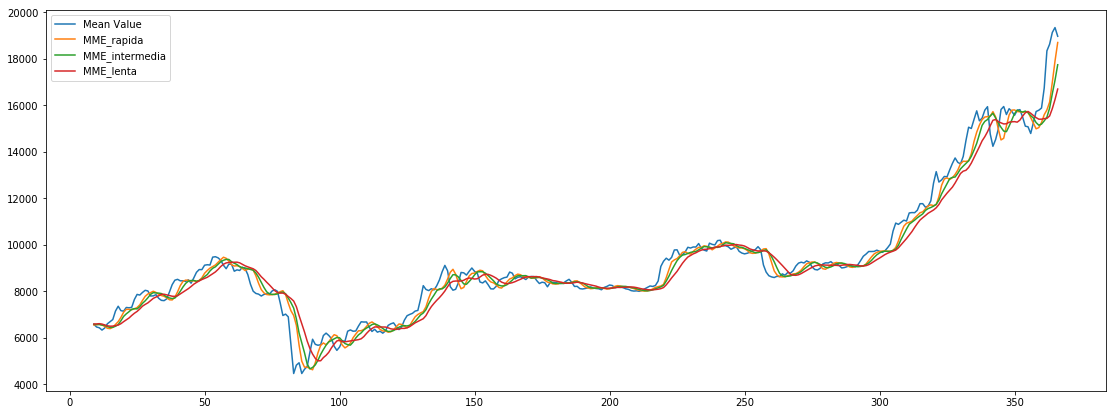



*********************
ESTRATEGIA BUY & HOLD
*********************

Compra el 2019-12-30 en 6608.40$
Venta el 2020-12-13 en 18877.51$. 
Para un capital de 100$, el beneficio es: 185.66$. Rentabilidad neta del 185.66%


*********************
ESTRATEGIA DE IMPULSO
*********************

Operación 0:
Capital inicial= 100
El día 2020-01-27 inicia una compra a 7974.51
El día 2020-02-15 se cierra una venta a 9332.60

Operación 1:
Capital total= 115.03$    Capital para la próxima inversión: 115.03$
El día 2020-03-06 inicia una compra a 8067.75
El día 2020-03-07 se cierra una venta a 7998.03

Operación 2:
Capital total= 111.74$    Capital para la próxima inversión: 111.74$
El día 2020-03-20 inicia una compra a 5937.81
El día 2020-03-27 se cierra una venta a 5965.39

Operación 3:
Capital total= 110.02$    Capital para la próxima inversión: 110.02$
El día 2020-03-31 inicia una compra a 5863.07
El día 2020-04-10 se cierra una venta a 6449.43

Operación 4:
Capital total= 118.82$    Capital para l

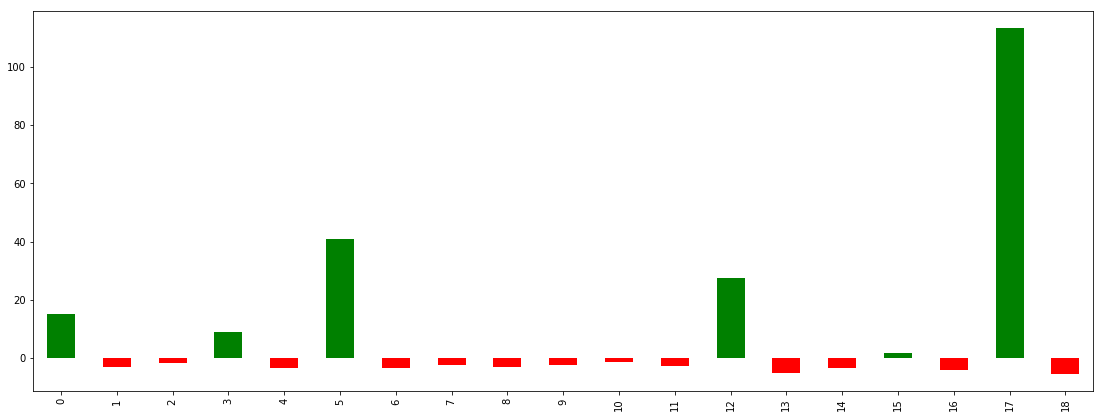

OPERACIONES GANADORAS: 32%
Beneficio para 100$: 165.06$
Rentabilidad neta: 165.06%
Se ha asegurado un capital de 0.00$ al retirar un 0.00% tras cada operación realizada


*************************
COMPARACIÓN DE RESULTADOS
*************************



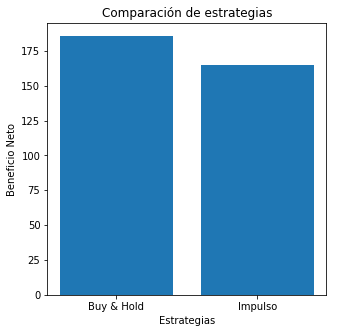

****************
RESUMEN DE DATOS
****************

Buy&Hold: con 100$, se obtiene un beneficio de 185.66$ en 2 operaciones. Rentabilidad del 185.66% 
Impulso: con 100$, se obtiene un beneficio de 165.06$ tras 40 operaciones. Rentabilidad del 165.06%
DIFERENCIA: -20.59$
OPERACIONES GANADORAS: 32%


In [17]:
df_mean=trade_comparison(csv,equity,n_acciones,secure_profit,comision_fija,comision_por_accion,ref_value,p_mmr,p_mmi,p_mml,dias,margen_error)